Task 3: Implement a program which,
- given even-numbered Caltec101 images,
 - creates an m-NN classifer (for a user specified m),
 - creates a decision-tree classifier,
 - creates a PPR based clasifier.

For this task, you can use feature space of your choice.
- for the odd numbered images, predicts the most likely labels using the user selected classifier.

The system should also output per-label precision, recall, and F1-score values as well as output an overall accuracy
value.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pickle

import heapq

import json
from torchvision.datasets import Caltech101
from torchvision.models  import resnet50, ResNet50_Weights
from torchvision import models, transforms
from scipy.special import softmax

import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cosine, minkowski, correlation
from PIL import Image
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import collections
import scipy.sparse as sp
from collections import Counter, defaultdict
from IPython.display import display, clear_output

In [3]:
path = '/content/drive/MyDrive/CSE515_Phase3'

In [4]:
caltech_dataset = Caltech101(root = f'{path}/data', download = False)

In [5]:
with open(f'{path}/label_image_map.json','r') as fp:
    label_image_map = json.load(fp)

In [6]:
label_file_path = f"{path}/LabelsWithImages.json"
with open(label_file_path, 'r') as file:
  label_dict = json.load(file)

In [7]:
json_file = f"{path}/feature_descriptors.json"
with open(json_file, 'r') as file:
  feature_descriptors = json.load(file)

data = pd.DataFrame(feature_descriptors).T.reset_index(names="id")

Below is the implementation of KNN from scratch.

In [8]:
class KNNClassifier:
    def __init__(self, k):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def euclidean_distance(self, a, b):
        return np.linalg.norm(a - b)

    def get_neighbors(self, test_instance):
        neighbors_heap = []
        for i, train_instance in enumerate(self.X_train):
            dist = self.euclidean_distance(test_instance, train_instance)
            if len(neighbors_heap) < self.k:
                heapq.heappush(neighbors_heap, (-dist, i))
            else:
                heapq.heappushpop(neighbors_heap, (-dist, i))
        return [i for _, i in sorted(neighbors_heap, reverse=True)]

    def predict_classification(self, test_instance):
        neighbors = self.get_neighbors(test_instance)
        neighbor_labels = [self.y_train[i] for i in neighbors]
        label_counts = Counter(neighbor_labels)
        most_common_label = label_counts.most_common(1)[0][0]
        return most_common_label

    def predict(self, X_test):
        predictions = []
        i = 0
        for test_instance in X_test:
            prediction = self.predict_classification(test_instance)
            predictions.append(prediction)
            i = i + 1
            message = f"Predicting test instance: {i}/{4338}"
            clear_output(wait=True)
            display(message)

        return predictions

Below is the implementation of PPR based classifier.

In [9]:
class PPRClassifier:
    def __init__(self, n, m, beta=0.15, max_iterations=100, tolerance=1e-6):
        self.n = n
        self.m = m
        self.beta = beta
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.graph = None
        self.labels = None
        self.train_features = None
        self.label_representatives = {}

    def fit(self, train_features, train_labels):
        self.train_features = train_features
        self.labels = train_labels
        similarities = self.compute_similarities(train_features)
        self.graph = self.compute_graph(len(train_features), similarities, self.n)
        self.compute_label_representatives()

    def compute_similarities(self, features):
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        similarities = cosine_similarity(features)
        return similarities

    def compute_graph(self, num_images, similarities, n):
        adj_matrix = np.zeros((num_images, num_images), dtype=float)
        for i in range(num_images):
            similar_indices = np.argsort(similarities[i])[::-1]
            neighbors = similar_indices[1:n + 1]
            adj_matrix[i, neighbors] = 1 / n
        return adj_matrix

    def personalized_pagerank(self, personalization_vector):
        num_nodes = len(self.graph)
        pagerank = np.ones(num_nodes) / num_nodes
        teleportation_vector = (self.beta) * personalization_vector / np.sum(personalization_vector)
        graph = sp.csr_matrix(self.graph)
        for iteration in range(self.max_iterations):
            prev_pagerank = pagerank.copy()
            pagerank = teleportation_vector + (1 - self.beta) * graph.dot(pagerank)
            if np.sum(np.abs(pagerank - prev_pagerank)) < self.tolerance:
                break
        return pagerank

    def compute_label_representatives(self):
        for label in set(self.labels):
            message = f"Computing representatives of label: {label}/{100}"
            clear_output(wait=True)
            display(message)
            personalization_vector = np.zeros(len(self.graph), dtype=float)
            for index in label_dict[str(label)]:
                personalization_vector[int(index/2)] = 1.0
            pagerank_scores = self.personalized_pagerank(personalization_vector)
            top_m_image_ids = np.argsort(pagerank_scores)[::-1][:self.m]
            self.label_representatives[label] = top_m_image_ids

    def predict_classification(self, test_instance):
        similarities = {}
        for label, representative_indices in self.label_representatives.items():
            representative_data = self.train_features[representative_indices]
            similarity = cosine_similarity([test_instance], representative_data)
            similarities[label] = np.mean(similarity)
        predicted_label = max(similarities, key=similarities.get)
        return predicted_label

    def predict(self, test_features):
        predictions = []
        i = 0
        for test_instance in test_features:
            similarities = {}
            for label, representative_indices in self.label_representatives.items():
                representative_data = self.train_features[representative_indices]
                similarity = cosine_similarity([test_instance], representative_data)
                similarities[label] = np.mean(similarity)
            predicted_label = max(similarities, key=similarities.get)
            predictions.append(predicted_label)
            i = i + 1
            message = f"Predicting test instance: {i}/{4338}"
            clear_output(wait=True)
            display(message)
        return predictions

In [10]:
def calculate_classification_metrics(actual_labels, predicted_labels):
  unique_labels = list(range(101))
  per_label_precision, per_label_recall, per_label_f1_score = calculate_per_label_metrics(actual_labels, predicted_labels)
  for label, precision, recall, f1 in zip(unique_labels, per_label_precision, per_label_recall, per_label_f1_score):
      print(f"Label {label}: Precision={precision:.2f}, Recall={recall:.2f}, F1 Score={f1:.2f}")

  overall_accuracy = calculate_accuracy(actual_labels, predicted_labels)

  print(f"Over all accuracy for the model is = {round(overall_accuracy*100,2)} %")

In [11]:
def get_svd_latent_features(k, feature_vector, data ):
    feature_vectors = np.vstack(data[feature_vector].to_numpy())

    ATA = np.dot(feature_vectors.T, feature_vectors)


    eigenvalues_ATA, eigenvectors_ATA = np.linalg.eigh(ATA)

    sorted_indices = eigenvalues_ATA.argsort()[::-1]
    eigenvalues_ATA = eigenvalues_ATA[sorted_indices]
    eigenvectors_ATA = eigenvectors_ATA[:, sorted_indices]


    singular_values = np.sqrt(eigenvalues_ATA)
    singular_values = np.real(singular_values)
    right_singular_vectors = eigenvectors_ATA

    left_singular_vectors = np.dot(feature_vectors, right_singular_vectors)
    for i in range(left_singular_vectors.shape[1]):
        left_singular_vectors[:, i] /= singular_values[i]

    right_singular_vectors = right_singular_vectors[:,:k]

    latent_weights = left_singular_vectors


    svd_weights = {}
    for i in range(len(latent_weights)):
        svd_weights[i] = np.real(latent_weights[i][:k]).tolist()

    return svd_weights,{"V":np.real(right_singular_vectors).tolist(),"sigma":np.real(singular_values).tolist(), "k":k}

def transform_odd_images_to_latent_space(latent_space, image_feature_vector):
    transformed_latent_space_vector = np.dot(np.array(image_feature_vector).reshape(1,-1), np.array(latent_space["V"]))
    for i in range(transformed_latent_space_vector.shape[1]):
        transformed_latent_space_vector[:, i] /= latent_space["sigma"][i]
    return transformed_latent_space_vector.squeeze()

def calculate_latent_semantics(k, data):
  feature_space = "layer_3"
  weights, latent_feature_space = get_svd_latent_features(k,feature_space,data)

  return weights, latent_feature_space

def get_label_for_odd_images_comb( odd_image_features, latent_feature_space):
    latent_vectors = []
    for odd_feature in odd_image_features:
        latent_vectors.append(transform_odd_images_to_latent_space(latent_feature_space, odd_feature))

    return latent_vectors

def construct_tree_gini(node):
    if node is None:
        return None
    left_node = construct_tree_gini(node["left"])
    right_node = construct_tree_gini(node["right"])
    new_node = Node(feature=int(node["feature"]) if node["feature"] is not None else None,
                    threshold=float(node["threshold"]) if node["threshold"] is not None else None,
                    left=left_node, right=right_node,
                    value=float(node["value"]) if node["value"] is not None else None)
    return new_node

# Node class to store all the nodes of the decision tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

class DecisionTreeClassifier:
    def __init__(self, max_depth=None,min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split

    def fit(self, X, y):
        self.num_classes = len(np.unique(y))
        self.root = self._build_tree(X, y, depth=0)

    # Function to calculate gini impurity which is used  as the feature splitting criterion
    def _calculate_gini(self, y):
        m = len(y)
        gini = 1.0
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / m
        gini -= np.sum(probabilities ** 2)
        return gini

    # Function to split the data based on the threshold value
    def _split_data(self, X, y, split_feature, split_value):
        left_mask = X[:, split_feature] <= split_value
        right_mask = ~left_mask
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _find_best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        current_gini = self._calculate_gini(y)

        best_gini = 1.0
        best_split_feature = None
        best_split_value = None


        # Find the best split by calculating gini impurity for each feature and the corresponding threshold values
        for feature_index in range(n):
            feature_values = np.unique(X[:, feature_index])
            for value in feature_values:
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, value)

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                left_gini = self._calculate_gini(y_left)
                right_gini = self._calculate_gini(y_right)

                weighted_gini = (len(y_left) / m) * left_gini + (len(y_right) / m) * right_gini

                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_split_feature = feature_index
                    best_split_value = value

        return best_split_feature, best_split_value

    def _build_tree(self, X, y, depth):

        self.depth = depth

        self.n_samples, self.n_features = X.shape

        # Stopping criteria for the decision tree - based on the max depth of the tree, minimum number of samples per node and whether a node is pure or not
        if depth == self.max_depth or len(np.unique(y)) == 1 or self.n_samples < self.min_samples_split:
            return Node(value = np.bincount(y).argmax())

        best_split_feature, best_split_value = self._find_best_split(X, y)

        if best_split_feature is None:
            return Node(value= np.bincount(y).argmax())

        X_left, y_left, X_right, y_right = self._split_data(X, y, best_split_feature, best_split_value)

        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        return Node(feature = best_split_feature, threshold = best_split_value, left = left_subtree, right = right_subtree)

    # Traverse the tree by comparing threshold value at each node and assign a label when you encounter a leaf node
    def predict_classification(self, instance, node):
        if node.is_leaf():
            return int(node.value)
        if instance[node.feature] <= node.threshold:
            return self.predict_classification(instance, node.left)
        else:
            return self.predict_classification(instance, node.right)

    def predict(self, X):
        predictions = []
        i = 0
        for test_instance in X:
          predicted_label = self.predict_classification(test_instance, self.root)
          predictions.append(predicted_label)
          i = i + 1
          message = f"Predicting test instance: {i}/{4338}"
          clear_output(wait=True)
          display(message)

        return predictions


In [12]:
def calculate_per_label_metrics(actual_labels, predicted_labels):
    unique_labels = set(actual_labels + predicted_labels)
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    label_count = len(unique_labels)

    true_positives = [0] * label_count
    false_positives = [0] * label_count
    false_negatives = [0] * label_count

    for actual, predicted in zip(actual_labels, predicted_labels):
        actual_index = label_to_index[actual]
        predicted_index = label_to_index[predicted]

        if actual == predicted:
            true_positives[actual_index] += 1
        else:
            false_positives[predicted_index] += 1
            false_negatives[actual_index] += 1

    precision = [true_positives[i] / (true_positives[i] + false_positives[i] + 1e-10) for i in range(label_count)]
    recall = [true_positives[i] / (true_positives[i] + false_negatives[i] + 1e-10) for i in range(label_count)]
    f1_score = [2 * (p * r) / (p + r + 1e-10) for p, r in zip(precision, recall)]

    return precision, recall, f1_score

def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for a, p in zip(actual_labels, predicted_labels) if a == p)
    accuracy = correct_predictions / len(actual_labels)
    return accuracy

In [13]:
def custom_classification_report(labels, precision, recall, f1_score):
    print("{:<10} {:<10} {:<10} {:<10}".format("Label", "Precision", "Recall", "F1-Score"))
    print("="*40)
    for label, p, r, f1 in zip(labels, precision, recall, f1_score):
      print("{:<10} {:<10.2f} {:<10.2f} {:<10.2f}".format(label, p, r, f1))

In [14]:
X_train = np.array(data["layer_3"].tolist())

even_indices = [i for i in range(0, len(caltech_dataset), 2)]
odd_indices = [i for i in range(1, len(caltech_dataset), 2)]

y_train = np.array([caltech_dataset.y[idx] for idx in even_indices])

y_test = np.array([caltech_dataset.y[idx] for idx in odd_indices])

with open(f'{path}/feature_descriptors_odd_images.json', 'r') as file:
  feature_descriptors_odd_images = json.load(file)

features_odd_images = list(feature_descriptors_odd_images.values())

# Convert the list of feature lists to a NumPy array
X_test = np.array(features_odd_images)

# k = 92
# weights,latent_space = calculate_latent_semantics(k, data)
# new_weights = [np.array(weight).round(3) for _,weight in weights.items()]

# latent_vectors = get_label_for_odd_images_comb( X_test, latent_space)
# latent_vectors = [vector.tolist() for vector in latent_vectors]
# with open(f"/content/drive/MyDrive/CSE515_Phase3/odd_images_layer3_latent_SVD_{k}.json","w") as f:
#   json.dump(latent_vectors,f)

# with open("/content/drive/MyDrive/CSE515_Phase3/odd_images_layer3_latent_SVD_92.json","r") as f:
#   latent_vectors = json.load(f)

In [15]:
classifier = None
while classifier is None:
    classifier_type = int(input("Choose the classifier to use:\n1. KNN 2. Decision Tree 3. PPR: "))

    if classifier_type == 1:
        k = int(input("Enter the value of k representing the number of neighbors for KNN search: "))
        knn_classifier = KNNClassifier(k)
        knn_classifier.fit(X_train, y_train)
        classifier = knn_classifier
    elif classifier_type == 2:
        choice = int(input("Choose one 1. saved classifier 2. train classifier (Takes Long Time) : "))
        classifier = DecisionTreeClassifier(min_samples_split=25)

        if choice == 1:
          with open("/content/drive/MyDrive/CSE515_Phase3/latent_spaces/decision_tree_layer3.json","r") as f:
            root_node = json.load(f)
          root_node = construct_tree_gini(root_node)
          classifier.root = root_node

        elif choice == 2:
          classifier.fit(np.array(X_train),np.array(y_train))

    elif classifier_type == 3:
        m = int(input("Enter the value of m: "))
        beta = float(input("Enter the damping factor, beta: "))
        ppr_classifier = PPRClassifier(200, m, beta)
        ppr_classifier.fit(X_train, y_train)
        classifier = ppr_classifier
    else:
        print("Invalid classifier choice. Please choose a valid option.")

if classifier_type == 2:
  new_x_test = [np.array(val).round(2) for val in X_test]
  y_pred = classifier.predict(new_x_test)
else:
  y_pred = classifier.predict(X_test)

overall_accuracy = calculate_accuracy(list(y_test), y_pred)


calculate_classification_metrics(list(y_test), list(y_pred))

labels = list(range(101))

print(f"Overall accuracy: {round(overall_accuracy*100,2)} %")

'Predicting test instance: 4338/4338'

Label 0: Precision=0.88, Recall=0.89, F1 Score=0.88
Label 1: Precision=0.94, Recall=0.93, F1 Score=0.93
Label 2: Precision=0.59, Recall=0.62, F1 Score=0.60
Label 3: Precision=0.80, Recall=0.85, F1 Score=0.83
Label 4: Precision=0.14, Recall=0.30, F1 Score=0.19
Label 5: Precision=0.61, Recall=0.74, F1 Score=0.67
Label 6: Precision=0.00, Recall=0.00, F1 Score=0.00
Label 7: Precision=0.09, Recall=0.05, F1 Score=0.06
Label 8: Precision=0.09, Recall=0.21, F1 Score=0.12
Label 9: Precision=0.04, Recall=0.07, F1 Score=0.05
Label 10: Precision=0.00, Recall=0.00, F1 Score=0.00
Label 11: Precision=0.04, Recall=0.06, F1 Score=0.05
Label 12: Precision=0.40, Recall=0.48, F1 Score=0.44
Label 13: Precision=0.39, Recall=0.53, F1 Score=0.45
Label 14: Precision=0.00, Recall=0.00, F1 Score=0.00
Label 15: Precision=0.18, Recall=0.31, F1 Score=0.23
Label 16: Precision=0.30, Recall=0.15, F1 Score=0.20
Label 17: Precision=0.00, Recall=0.00, F1 Score=0.00
Label 18: Precision=0.04, Recall=0.05, F1 Score=0.04
Lab

Enter the image id of the odd numbered image you want to predict label: 1
Query Image


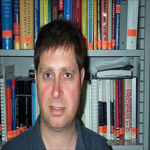

Predicted Label:  0
Query Image is classified as:  Faces_2


In [ ]:
input_image_id = int(input("Enter the image id of the odd numbered image you want to predict label: "))
print("Query Image")
display(caltech_dataset[int(input_image_id)][0].resize((150,150)))

test_instance = X_test[input_image_id]

if classifier_type == 2:
  predicted_label = classifier.predict_classification(test_instance, classifier.root)
else:
  predicted_label = classifier.predict_classification(test_instance)
print("Predicted Label: ", predicted_label)
print("Query Image is classified as: ", caltech_dataset.annotation_categories[int(predicted_label)])